In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Uplift analysis and attribution estimation
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint


import os

import warnings 
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/marketing-ab-testing/marketing_AB.csv


In [2]:
# Load dataset
df = pd.read_csv('/kaggle/input/marketing-ab-testing/marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [3]:
# Basic Info
print(df.shape)
print(df.nunique())
print(df.info())

(588101, 7)
Unnamed: 0       588101
user id          588101
test group            2
converted             2
total ads           807
most ads day          7
most ads hour        24
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB
None


**group-wise stats**

In [4]:
# Type of users in test group
df['test group'].value_counts()

test group
ad     564577
psa     23524
Name: count, dtype: int64

In [5]:
# Count of conversions by test group
conversion_counts = df.groupby('test group')['converted'].sum().reset_index()
conversion_counts

,test group,converted
0,ad,14423
1,psa,420


In [6]:
# Compute conversion rate
conversion_rates = df.groupby('test group')['converted'].mean().reset_index()
conversion_rates

,test group,converted
0,ad,0.025547
1,psa,0.017854


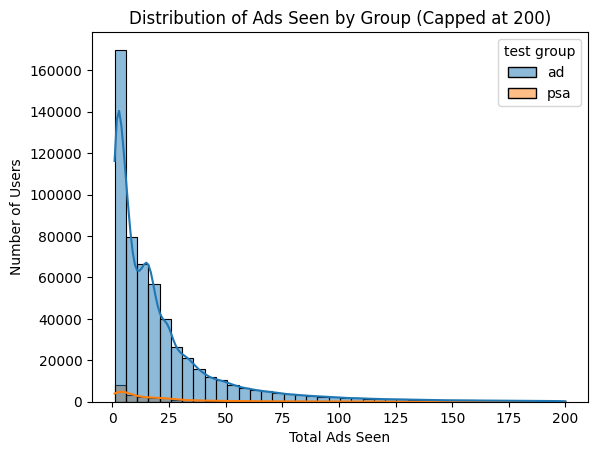

In [7]:
# Filter to users who saw <= 200 ads
filtered_df = df[df['total ads'] <= 200]

# Plot filtered histogram by group
sns.histplot(data=filtered_df, x='total ads', hue='test group', kde=True, bins=40)
plt.title("Distribution of Ads Seen by Group (Capped at 200)")
plt.xlabel("Total Ads Seen") 
plt.ylabel("Number of Users")
plt.show()

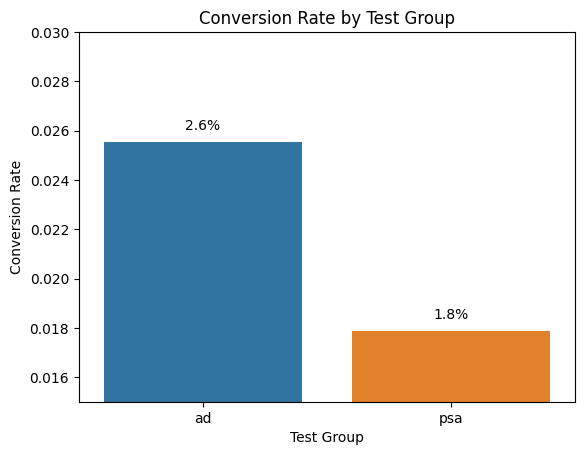

In [8]:
# Overall Conversion rate by group
conversion_rates = df.groupby('test group')['converted'].mean().reset_index()

# Bar plot of conversion rates
ax = sns.barplot(data=conversion_rates, x='test group', y='converted')
plt.title("Conversion Rate by Test Group")
plt.ylabel("Conversion Rate")
plt.xlabel("Test Group")
plt.ylim(0.015, 0.03)

# Add value labels to bars
for i, row in conversion_rates.iterrows():
    ax.text(i, row['converted'] + 0.0005, f"{row['converted']:.1%}", ha='center')

plt.show()

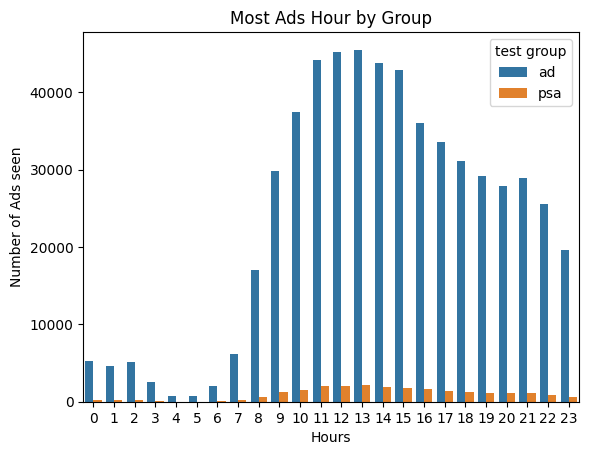

In [9]:
# Count of most ads hour
sns.countplot(data=df, x='most ads hour', hue='test group')
plt.title("Most Ads Hour by Group")
plt.ylabel("Number of Ads seen")
plt.xlabel("Hours")
plt.show()

Morning to early noon hours - 10 am to 3pm are PEAK AD HOURS

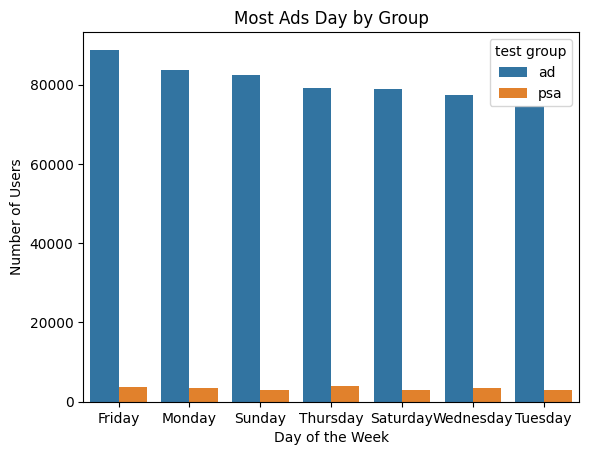

In [10]:
# Count of most ads day in descending order by total ads
most_ads_day_order = df['most ads day'].value_counts().sort_values(ascending=False).index
sns.countplot(data=df, x='most ads day', hue='test group', order=most_ads_day_order)
plt.title("Most Ads Day by Group")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Users")
plt.show()

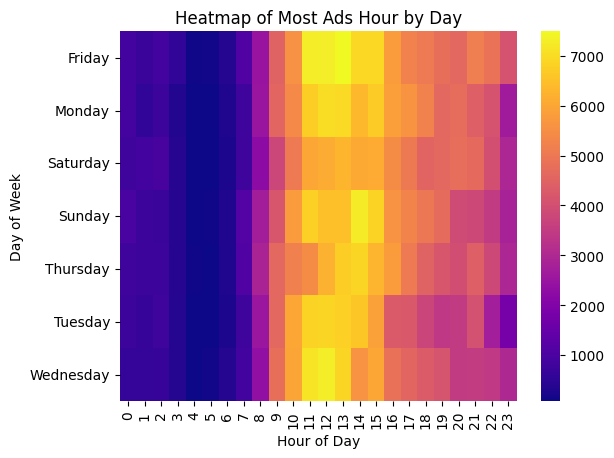

In [11]:
# Heatmap of most ads hour by most ads day
heatmap_data = df.groupby(['most ads day', 'most ads hour']).size().unstack()
sns.heatmap(heatmap_data, cmap='plasma')
plt.title("Heatmap of Most Ads Hour by Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

Heatmap clearly shows how middle of the day 10 am to 3pm.

**CHECK FOR OUTLIERS**

In [12]:
# Log(1 + Total Ads) ~Approx. Total Ads Seen
# 1	~1.72 ads
# 2	~6.39 ads
# 3	~19.09 ads
# 4	~53.60 ads
# 5	~147.41 ads
# 6	~402.43 ads
# 7	~1095.63 ads

Max total ads seen: 2065


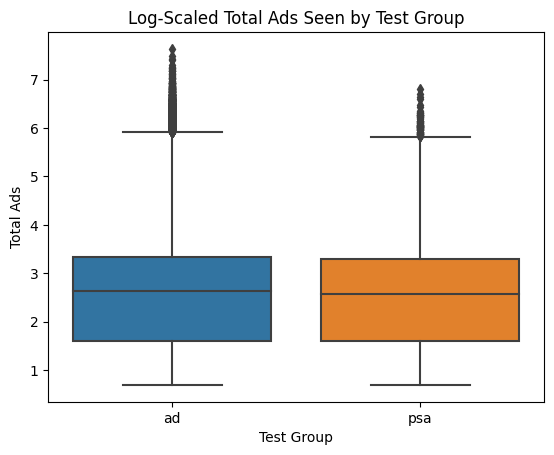

In [13]:
# Check original max value
print("Max total ads seen:", df['total ads'].max())

# Add a log-transformed column (add 1 to avoid log(0))
df['log_total_ads'] = np.log1p(df['total ads'])

# Boxplot using log-transformed data
sns.boxplot(data=df, x='test group', y='log_total_ads')
plt.title("Log-Scaled Total Ads Seen by Test Group")
plt.xlabel("Test Group")
plt.ylabel("Total Ads")
plt.show()

Majority of the test group users saw between 5 to 25 ads. 24 being the avg ads seen.

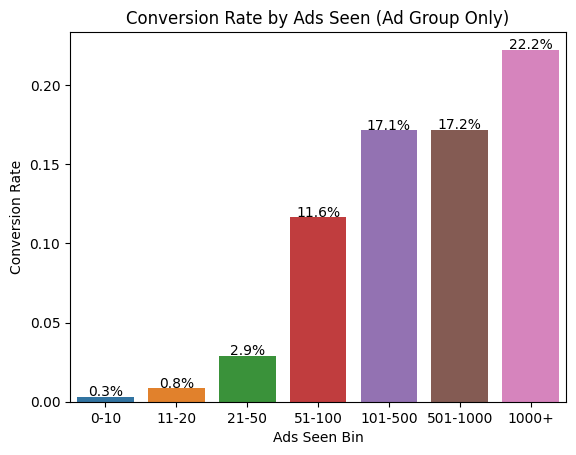

    ads_bin  converted
0      0-10   0.003259
1     11-20   0.008400
2     21-50   0.029154
3    51-100   0.116311
4   101-500   0.171258
5  501-1000   0.171698
6     1000+   0.222222


In [14]:
# Binning total ads into fixed ranges for test group 'ad'
ad_group = df[df['test group'] == 'ad']
ad_group['ads_bin'] = pd.cut(
    ad_group['total ads'],
    bins=[0, 10, 20, 50, 100, 500, 1000, ad_group['total ads'].max()],
    labels=['0-10','11-20','21-50','51-100','101-500','501-1000','1000+'],
    include_lowest=True
)

# Compute conversion rate per bin
conversion_by_ads_bin = ad_group.groupby('ads_bin')['converted'].mean().reset_index()

# Bar plot of conversion rate by total ads seen bin
ax = sns.barplot(data=conversion_by_ads_bin, x='ads_bin', y='converted')
plt.title("Conversion Rate by Ads Seen (Ad Group Only)")
plt.ylabel("Conversion Rate")
plt.xlabel("Ads Seen Bin")

# Add value labels to bars
for i, row in conversion_by_ads_bin.iterrows():
    ax.text(i, row['converted'] + 0.0005, f"{row['converted']:.1%}", ha='center')

plt.show()

# Optional: Display conversion rates
print(conversion_by_ads_bin)

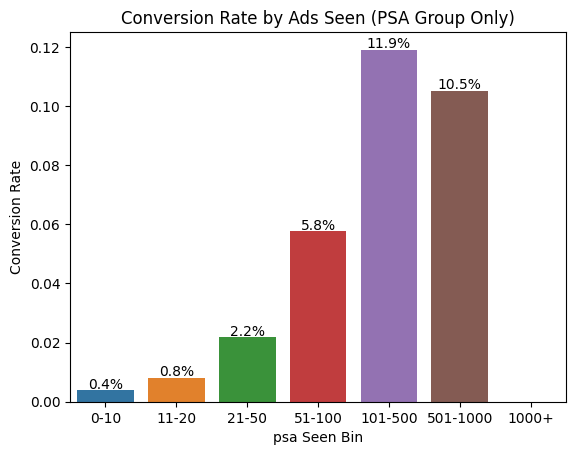

    ads_bin  converted
0      0-10   0.003991
1     11-20   0.008193
2     21-50   0.021777
3    51-100   0.057744
4   101-500   0.119072
5  501-1000   0.105263
6     1000+        NaN


In [15]:
# Binning total ads into fixed ranges for test group 'psa'
psa_group = df[df['test group'] == 'psa']
psa_group['ads_bin'] = pd.cut(
    psa_group['total ads'],
    bins=[0, 10, 20, 50, 100, 500, 1000, ad_group['total ads'].max()],
    labels=['0-10','11-20','21-50','51-100','101-500','501-1000','1000+'],
    include_lowest=True
)

# Compute conversion rate per bin
conversion_by_ads_bin = psa_group.groupby('ads_bin')['converted'].mean().reset_index()

# Bar plot of conversion rate by total ads seen bin
ax = sns.barplot(data=conversion_by_ads_bin, x='ads_bin', y='converted')
plt.title("Conversion Rate by Ads Seen (PSA Group Only)")
plt.ylabel("Conversion Rate")
plt.xlabel("psa Seen Bin")

# Add value labels to bars
for i, row in conversion_by_ads_bin.iterrows():
    ax.text(i, row['converted'] + 0.0005, f"{row['converted']:.1%}", ha='center')

plt.show()

# Optional: Display conversion rates
print(conversion_by_ads_bin)


In [16]:
# Crosstab of conversion by test group
pd.crosstab(df['test group'], df['converted'], margins=True, normalize='index')

converted,False,True
test group,,
ad,0.974453,0.025547
psa,0.982146,0.017854
All,0.974761,0.025239


In [17]:
# Pearson correlation between number of ads seen and conversion
# Convert boolean to int for correlation
df['converted_int'] = df['converted'].astype(int)

In [18]:
# Separate by group
ad_group = df[df['test group'] == 'ad']
psa_group = df[df['test group'] == 'psa']

In [19]:
# Calculate correlations
ad_corr = ad_group[['total ads', 'converted_int']].corr().loc['total ads', 'converted_int']
ad_corr

0.21865536514603628

In [20]:
psa_corr = psa_group[['total ads', 'converted_int']].corr().loc['total ads', 'converted_int']
psa_corr

0.1840765341425704

**CHECK UPLIFT**

In [21]:
# Count conversions and totals for both groups
ad_converted = df[df['test group'] == 'ad']['converted'].sum()
ad_total = df[df['test group'] == 'ad'].shape[0]

psa_converted = df[df['test group'] == 'psa']['converted'].sum()
psa_total = df[df['test group'] == 'psa'].shape[0]

In [22]:
# Calculate conversion rates
conversion_rate_ad = ad_converted / ad_total
conversion_rate_psa = psa_converted / psa_total

uplift = conversion_rate_ad - conversion_rate_psa

In [23]:
print(f"Ad Group Conversion Rate: {conversion_rate_ad:.3%}")
print(f"PSA Group Conversion Rate: {conversion_rate_psa:.3%}")
print(f"Uplift: {uplift:.3%}")

Ad Group Conversion Rate: 2.555%
PSA Group Conversion Rate: 1.785%
Uplift: 0.769%


In [24]:
# Z-test for proportions
ad_count = [ad_converted, psa_converted]
ad_count

[14423, 420]

In [25]:
ad_nobs = [ad_total, psa_total]
ad_nobs

[564577, 23524]

In [26]:
z_stat, p_value = proportions_ztest(ad_count, ad_nobs, alternative='larger')

print(f"Z-statistic: {z_stat:.5f}")
print(f"P-value: {p_value:.5f}")

Z-statistic: 7.37008
P-value: 0.00000


The p-value is far below 0.05, so we reject the null hypothesis.
There is strong statistical evidence that the ad_group had a higher conversion rate than the PSA group.
Therefore, the uplift is real and statistically significant.

In [27]:
# Attribution & Incremental Conversions
# (0.77% * 564577)
incremental_conversions = uplift * ad_total 
print(f"Estimated Incremental Conversions from Ads: {int(incremental_conversions)}")

Estimated Incremental Conversions from Ads: 4342


In [28]:
# Revenue per conversion (assume)
avg_revenue_per_conversion = 50  # adjust as needed
incremental_revenue = incremental_conversions * avg_revenue_per_conversion
print(f"Estimated Incremental Revenue: ${incremental_revenue:,.2f}")

Estimated Incremental Revenue: $217,149.11


In [29]:
# Summary printout for uplift and statistical significance
print("\n--- Uplift Summary ---")
print(f"Ad Group Conversion Rate: {conversion_rate_ad:.2%}")
print(f"PSA Group Conversion Rate: {conversion_rate_psa:.2%}")
print(f"Absolute Uplift: {uplift:.2%}")
print(f"Z-Statistic: {z_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print(f"Statistically Significant: {'Yes' if p_value < 0.05 else 'No'}")
print(f"Incremental Conversions: {int(incremental_conversions)}")
print(f"Estimated Incremental Revenue (at ${avg_revenue_per_conversion} per conversion): ${incremental_revenue:,.2f}")



--- Uplift Summary ---
Ad Group Conversion Rate: 2.55%
PSA Group Conversion Rate: 1.79%
Absolute Uplift: 0.77%
Z-Statistic: 7.37
P-Value: 0.0000
Statistically Significant: Yes
Incremental Conversions: 4342
Estimated Incremental Revenue (at $50 per conversion): $217,149.11
